In [1]:
PATH = 'D:/IPYNB/Ipynb project/project/New Notebooks/'

In [2]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# featuretools for automated feature engineering
import featuretools as ft

# matplotlit and seaborn for visualizations
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 22
import seaborn as sns

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

# modeling 
import lightgbm as lgb

# utilities
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

# memory management
import gc

### * `train_bureau` is the training features built manually using the `bureau` and `bureau_balance` data
### * `train_previous` is the training features built manually using the `previous`, `cash`, `credit`, and `installments` data

We first see how many features we built over the manual engineering process. Here we use a couple of set operations to find the columns that are only in the `bureau`, only in the `previous`, and in both dataframes, indicating that there are `original` features from the `application` dataframe. Here we work with a small subset of the data in order to not overwhelm the machine. This code has also been run on the full dataset (we will take a look at some of the results).

In [3]:
# Read in data
train_bureau = pd.read_csv(f'{PATH}home-credit-manual-engineered-features/train_bureau_raw.csv', nrows = 1000)
test_bureau = pd.read_csv(f'{PATH}home-credit-manual-engineered-features/test_bureau_raw.csv', nrows = 1000)

train_previous = pd.read_csv(f'{PATH}home-credit-manual-engineered-features/train_previous_raw.csv', nrows = 1000)
test_previous = pd.read_csv(f'{PATH}home-credit-manual-engineered-features/test_previous_raw.csv', nrows = 1000)

# All columns in dataframes
bureau_columns = list(train_bureau.columns)
previous_columns = list(train_previous.columns)

In [4]:
# Bureau only features
bureau_features = list(set(bureau_columns) - set(previous_columns))

# Previous only features
previous_features = list(set(previous_columns) - set(bureau_columns))

# Original features will be in both datasets
original_features = list(set(previous_columns) & set(bureau_columns))

print('There are %d original features.' % len(original_features))
print('There are %d bureau and bureau balance features.' % len(bureau_features))
print('There are %d previous Home Credit loan features.' % len(previous_features))

There are 123 original features.
There are 179 bureau and bureau balance features.
There are 1043 previous Home Credit loan features.


### That gives us the number of features in each dataframe. Now we combine the data without creating any duplicate rows. 

In [5]:
train_labels = train_bureau['TARGET']
previous_features.append('SK_ID_CURR')

train_ids = train_bureau['SK_ID_CURR']
test_ids = test_bureau['SK_ID_CURR']

# Merge the dataframes avoiding duplicating columns by subsetting train_previous
train = train_bureau.merge(train_previous[previous_features], on = 'SK_ID_CURR')
test = test_bureau.merge(test_previous[previous_features], on = 'SK_ID_CURR')

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (1000, 1345)
Testing shape:  (1000, 1344)


In [6]:
# One hot encoding
train = pd.get_dummies(train)
test = pd.get_dummies(test)

# Match the columns in the dataframes
train, test = train.align(test, join = 'inner', axis = 1)
print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (1000, 1447)
Testing shape:  (1000, 1447)


### When we did this to the full dataset, we get __1465__ features. 

### Correcting Mistakes
When were doing manual feature engineering, we accidentally created some columns derived from the client id, `SK_ID_CURR`. As this is a unique identifier for each client, it should not have any predictive power, and we would not want to build a model trained on this "feature". So we remove any columns built on the `SK_ID_CURR`.

In [7]:
cols_with_id = [x for x in train.columns if 'SK_ID_CURR' in x]
cols_with_bureau_id = [x for x in train.columns if 'SK_ID_BUREAU' in x]
cols_with_previous_id = [x for x in train.columns if 'SK_ID_PREV' in x]
print('There are %d columns that contain SK_ID_CURR' % len(cols_with_id))
print('There are %d columns that contain SK_ID_BUREAU' % len(cols_with_bureau_id))
print('There are %d columns that contain SK_ID_PREV' % len(cols_with_previous_id))

train = train.drop(columns = cols_with_id)
test = test.drop(columns = cols_with_id)
print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

There are 49 columns that contain SK_ID_CURR
There are 0 columns that contain SK_ID_BUREAU
There are 0 columns that contain SK_ID_PREV
Training shape:  (1000, 1398)
Testing shape:  (1000, 1398)


### After applying this to the full dataset, we end up with 1416 features. More features might seem like a good thing, and they can be if they help our model learn. However, irrelevant features, highly correlated features, and missing values can prevent the model from learning and decrease generalization performance on the testing data. Therefore, we perform feature selection to keep only the most useful variables. We start feature selection by focusing on collinear variables.

### Remove Collinear Variables

Collinear variables are those which are highly correlated with one another. These can decrease the model's availablility to learn, decrease model interpretability, and decrease generalization performance on the test set, these are three things we want to increase, so removing collinear variables is a useful step. We establish an admittedly arbitrary threshold for removing collinear variables, and then remove one out of any pair of variables that is above that threshold. 

The code below identifies the highly correlated variables based on the absolute magnitude of the Pearson correlation coefficient being greater than 0.9. Again, this is not entirely accurate since we are dealing with such a limited section of the data.

This code is adapted from [work by Chris Albon](https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/).

### Identify Correlated Variables

In [8]:
# Threshold for removing correlated variables
threshold = 0.9

# Absolute value correlation matrix
corr_matrix = train.corr().abs()
corr_matrix.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
CNT_CHILDREN,1.000000,0.055960,0.036836,0.055732,0.035851,0.060210,0.303782,0.218535,0.211766,0.036960,...,0.096914,0.064817,0.024544,0.019465,0.005586,0.030986,0.001443,0.027967,0.004500,0.020465
AMT_INCOME_TOTAL,0.055960,1.000000,0.429317,0.491143,0.439981,0.184339,0.088743,0.208663,0.130682,0.045634,...,0.033574,0.064520,0.020186,0.058210,0.060465,0.080291,0.000218,0.043426,0.107476,0.030645
AMT_CREDIT,0.036836,0.429317,1.000000,0.797209,0.986046,0.074287,0.065100,0.116515,0.027876,0.022994,...,0.005136,0.011202,0.007313,0.060005,0.009795,0.098314,0.018123,0.009507,0.075595,0.009483
AMT_ANNUITY,0.055732,0.491143,0.797209,1.000000,0.799121,0.106685,0.019480,0.139220,0.059163,0.024020,...,0.011107,0.022890,0.017907,0.084270,0.022107,0.133969,0.036801,0.032497,0.098291,0.036308
AMT_GOODS_PRICE,0.035851,0.439981,0.986046,0.799121,1.000000,0.073531,0.058535,0.115613,0.034500,0.030878,...,0.002397,0.020737,0.000716,0.069845,0.014077,0.094081,0.012866,0.019114,0.082543,0.000395


In [9]:
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
CNT_CHILDREN,NaN,0.05596,0.036836,0.055732,0.035851,0.060210,0.303782,0.218535,0.211766,0.036960,...,0.096914,0.064817,0.024544,0.019465,0.005586,0.030986,0.001443,0.027967,0.004500,0.020465
AMT_INCOME_TOTAL,NaN,NaN,0.429317,0.491143,0.439981,0.184339,0.088743,0.208663,0.130682,0.045634,...,0.033574,0.064520,0.020186,0.058210,0.060465,0.080291,0.000218,0.043426,0.107476,0.030645
AMT_CREDIT,NaN,NaN,NaN,0.797209,0.986046,0.074287,0.065100,0.116515,0.027876,0.022994,...,0.005136,0.011202,0.007313,0.060005,0.009795,0.098314,0.018123,0.009507,0.075595,0.009483
AMT_ANNUITY,NaN,NaN,NaN,NaN,0.799121,0.106685,0.019480,0.139220,0.059163,0.024020,...,0.011107,0.022890,0.017907,0.084270,0.022107,0.133969,0.036801,0.032497,0.098291,0.036308
AMT_GOODS_PRICE,NaN,NaN,NaN,NaN,NaN,0.073531,0.058535,0.115613,0.034500,0.030878,...,0.002397,0.020737,0.000716,0.069845,0.014077,0.094081,0.012866,0.019114,0.082543,0.000395


### Drop Correlated Variables

In [10]:
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))

There are 585 columns to remove.


In [11]:
train = train.drop(columns = to_drop)
test = test.drop(columns = to_drop)

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (1000, 813)
Testing shape:  (1000, 813)


### Applying this on the entire dataset results in 538  collinear features removed.  

This has reduced the number of features singificantly, but it is likely still too many. At this point, we read in the full dataset after removing correlated variables for further feature selection.

The full datasets (after removing correlated variables) are available in `m_train_combined.csv` and `m_test_combined.csv`.

### Read in Full Dataset

Now we move on to the full set of features. These were built by applying the above steps to the entire `train_bureau` and `train_previous` files

In [12]:
train = pd.read_csv(f'{PATH}home-credit-manual-engineered-features/m_train_combined.csv')
test = pd.read_csv(f'{PATH}home-credit-manual-engineered-features/m_test_combined.csv')

In [13]:
print('Training set full shape: ', train.shape)
print('Testing set full shape: ' , test.shape)

Training set full shape:  (307511, 865)
Testing set full shape:  (48744, 864)


### Remove Missing Values

A relatively simple choice of feature selection is removing missing values. We have to decide what percentage of missing values is the minimum threshold for removing a column. Like many choices in machine learning, there is no right answer, and not even a general rule of thumb for making this choice. In this implementation, if any columns have greater than 75% missing values, they will be removed. 

Most models (including those in Sk-Learn) cannot handle missing values, so we have to fill these in before machine learning. The Gradient Boosting Machine ([(in LightGBM)](https://github.com/Microsoft/LightGBM/blob/master/docs/Advanced-Topics.rst)) can handle missing values. Imputing missing values always makes it little uncomfortable because we add information that actually isn't in the dataset.

In [14]:
# Train missing values (in percent)
train_missing = (train.isnull().sum() / len(train)).sort_values(ascending = False)
train_missing.head()

client_credit_AMT_PAYMENT_CURRENT_min_min            0.801438
client_credit_AMT_PAYMENT_CURRENT_mean_max           0.801438
client_credit_AMT_DRAWINGS_OTHER_CURRENT_min_mean    0.801178
client_credit_CNT_DRAWINGS_OTHER_CURRENT_min_max     0.801178
client_credit_AMT_DRAWINGS_ATM_CURRENT_mean_max      0.801178
dtype: float64

In [15]:
# Test missing values (in percent)
test_missing = (test.isnull().sum() / len(test)).sort_values(ascending = False)
test_missing.head()

client_credit_CNT_DRAWINGS_OTHER_CURRENT_max_max     0.773223
client_credit_CNT_DRAWINGS_POS_CURRENT_mean_max      0.773223
client_credit_CNT_DRAWINGS_ATM_CURRENT_min_max       0.773223
client_credit_AMT_DRAWINGS_OTHER_CURRENT_mean_min    0.773223
client_credit_CNT_DRAWINGS_POS_CURRENT_min_mean      0.773223
dtype: float64

In [16]:
# Identify missing values above threshold
train_missing = train_missing.index[train_missing > 0.75]
test_missing = test_missing.index[test_missing > 0.75]

all_missing = list(set(set(train_missing) | set(test_missing)))
print('There are %d columns with more than 75%% missing values' % len(all_missing))

There are 19 columns with more than 75% missing values


### We drop the columns, one-hot encode the dataframes, and then align the columns of the dataframes.

In [17]:
# Need to save the labels because aligning will remove this column
train_labels = train["TARGET"]
train_ids = train['SK_ID_CURR']
test_ids = test['SK_ID_CURR']

train = pd.get_dummies(train.drop(columns = all_missing))
test = pd.get_dummies(test.drop(columns = all_missing))

train, test = train.align(test, join = 'inner', axis = 1)

print('Training set full shape: ', train.shape)
print('Testing set full shape: ' , test.shape)

Training set full shape:  (307511, 845)
Testing set full shape:  (48744, 845)


In [18]:
train = train.drop(columns = ['SK_ID_CURR'])
test = test.drop(columns = ['SK_ID_CURR'])

### One method for doing this automatically is the [Recursive Feature Elimination method](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html) in Scikit-Learn.

Instead of doing this automatically, we perform our own feature removal by first removing all zero importance features from the model. If this leaves too many features, then we consider removing the features with the lowest importance. We use a Gradient Boosted Model from the LightGBM library to assess feature importances. If Scikit-Learn library is used, the LightGBM library has an API that makes deploying the model very similar to using a Scikit-Learn model. 

In [19]:
# Initialize an empty array to hold feature importances
feature_importances = np.zeros(train.shape[1])

# Create the model with several hyperparameters
model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')

In [20]:
# Fit the model twice to avoid overfitting
for i in range(2):
    
    # Split into training and validation set
    train_features, valid_features, train_y, valid_y = train_test_split(train, train_labels, test_size = 0.25, random_state = i)
    
    # Train using early stopping
    model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], 
              eval_metric = 'auc', verbose = 200)
    
    # Record the feature importances
    feature_importances += model.feature_importances_

Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.508306	valid_0's auc: 0.78221
Early stopping, best iteration is:
[160]	valid_0's binary_logloss: 0.517915	valid_0's auc: 0.783367
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.508221	valid_0's auc: 0.783794
Early stopping, best iteration is:
[125]	valid_0's binary_logloss: 0.527413	valid_0's auc: 0.784812


In [21]:
# Make sure to average feature importances! 
feature_importances = feature_importances / 2
feature_importances = pd.DataFrame({'feature': list(train.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)

feature_importances.head()

,feature,importance
24,EXT_SOURCE_1,149.0
25,EXT_SOURCE_2,122.5
368,client_installments_AMT_PAYMENT_min_sum,120.0
26,EXT_SOURCE_3,119.0
5,DAYS_BIRTH,95.0


In [22]:
# Find the features with zero importance
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))
feature_importances.tail()

There are 312 features with 0.0 importance


,feature,importance
433,previous_loans_NAME_CASH_LOAN_PURPOSE_Car repa...,0.0
432,client_cash_NAME_CONTRACT_STATUS_Completed_cou...,0.0
431,previous_loans_CHANNEL_TYPE_Car dealer_count,0.0
430,previous_loans_NAME_CASH_LOAN_PURPOSE_Repairs_...,0.0
843,EMERGENCYSTATE_MODE_Yes,0.0


### One of feature made it into the top 5 most important. That's a good sign our hard work making the features. It also looks like many of the features we made have literally 0 importance. For the gradient boosting machine, features with 0 importance are not used at all to make any splits. Therefore, we remove these features from the model with no effect on performance (except for faster training).

In [23]:
def plot_feature_importances(df, threshold = 0.9):
    """
    Plots 15 most important features and the cumulative importance of features.
    Prints the number of features needed to reach threshold cumulative importance.
    
    Parameters
    --------
    df : dataframe
        Dataframe of feature importances. Columns must be feature and importance
    threshold : float, default = 0.9
        Threshold for prining information about cumulative importances
        
    Return
    --------
    df : dataframe
        Dataframe ordered by feature importances with a normalized column (sums to 1)
        and a cumulative importance column
    
    """
    
    plt.rcParams['font.size'] = 18
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df

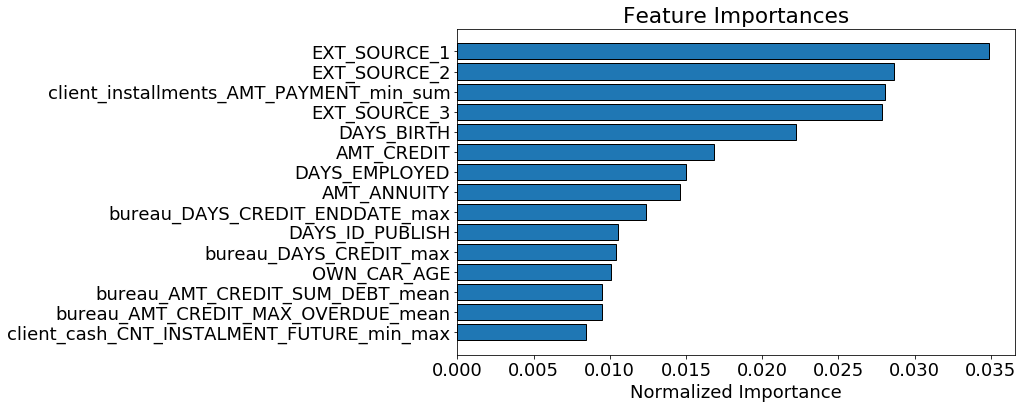

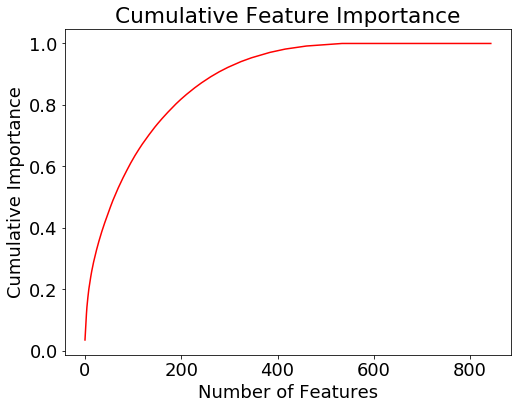

272 features required for 0.90 of cumulative importance


In [24]:
norm_feature_importances = plot_feature_importances(feature_importances)

### We remove the features that have zero importance.

In [25]:
train = train.drop(columns = zero_features)
test = test.drop(columns = zero_features)

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (307511, 532)
Testing shape:  (48744, 532)


### We now re-run the model to see if it identifies any more features with zero importance. In a way, we are implementing our form of recursive feature elimination. Since we are repeating work, we should put the zero feature importance identification code in a function.

In [26]:
def identify_zero_importance_features(train, train_labels, iterations = 2):
    """
    Identify zero importance features in a training dataset based on the 
    feature importances from a gradient boosting model. 
    
    Parameters
    --------
    train : dataframe
        Training features
        
    train_labels : np.array
        Labels for training data
        
    iterations : integer, default = 2
        Number of cross validation splits to use for determining feature importances
    """
    
    # Initialize an empty array to hold feature importances
    feature_importances = np.zeros(train.shape[1])

    # Create the model with several hyperparameters
    model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')
    
    # Fit the model multiple times to avoid overfitting
    for i in range(iterations):

        # Split into training and validation set
        train_features, valid_features, train_y, valid_y = train_test_split(train, train_labels, test_size = 0.25, random_state = i)

        # Train using early stopping
        model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], 
                  eval_metric = 'auc', verbose = 200)

        # Record the feature importances
        feature_importances += model.feature_importances_ / iterations
    
    feature_importances = pd.DataFrame({'feature': list(train.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)
    
    # Find the features with zero importance
    zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
    print('\nThere are %d features with 0.0 importance' % len(zero_features))
    
    return zero_features, feature_importances

In [27]:
second_round_zero_features, feature_importances = identify_zero_importance_features(train, train_labels)

Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.508382	valid_0's auc: 0.782907
Early stopping, best iteration is:
[160]	valid_0's binary_logloss: 0.517915	valid_0's auc: 0.783367
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.507452	valid_0's auc: 0.784651
Early stopping, best iteration is:
[156]	valid_0's binary_logloss: 0.518948	valid_0's auc: 0.785086

There are 0 features with 0.0 importance


### There are now no 0 importance features left. If we desire to remove more features, we have to start with features that have a non-zero importance. One way we could do this is by retaining enough features to account for a threshold percentage of importance, such as 95%. At this point, we keep enough features to account for 95% of the importance. Again, this is an arbitrary decision 

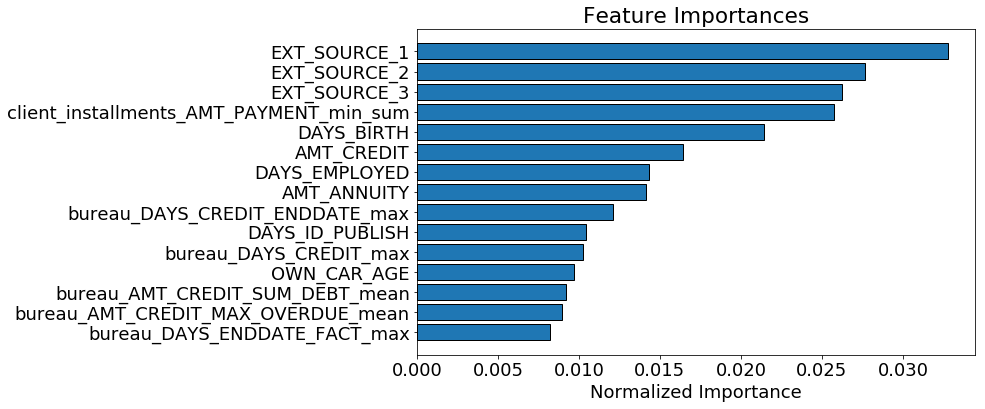

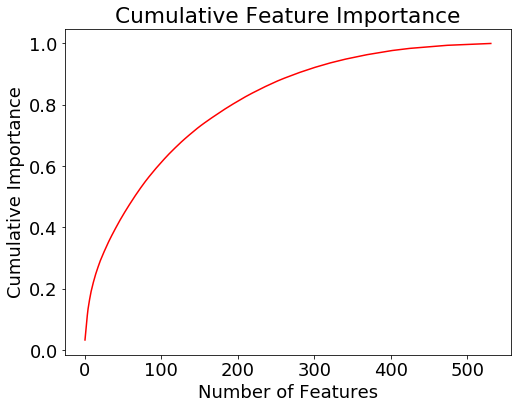

344 features required for 0.95 of cumulative importance


In [28]:
norm_feature_importances = plot_feature_importances(feature_importances, threshold = 0.95)

### We keep only the features needed for 95% importance. This step seems to have the greatest chance of harming the model's learning ability, so rather than changing the original dataset, we make smaller copies. Then, we test both versions of the data to see if the extra feature removal step is worthwhile. 

In [29]:
# Threshold for cumulative importance
threshold = 0.95

# Extract the features to keep
features_to_keep = list(norm_feature_importances[norm_feature_importances['cumulative_importance'] < threshold]['feature'])

# Create new datasets with smaller features
train_small = train[features_to_keep]
test_small = test[features_to_keep]

In [30]:
train_small['TARGET'] = train_labels
train_small['SK_ID_CURR'] = train_ids
test_small['SK_ID_CURR'] = test_ids

#train_small.to_csv('m_train_small.csv', index = False)
#test_small.to_csv('m_test_small.csv', index = False)

### Test New Featuresets

The last step of feature removal we did, may have the potential to hurt the model the most. Therefore we test the effect of this removal. To do that, we use a standard model and change the features. 

We use a fairly standard LightGBM model, similar to the one we used for feature selection. The main difference is this model uses five-fold cross validation for training and we use it to make predictions. There's a lot of code here, but that's because we included documentation and a few extras (such as feature importances) that aren't strictly necessary. We use the same model with two different datasets to see which one performs the best.

In [31]:
def model(features, test_features, encoding = 'ohe', n_folds = 5):
    
    """Train and test a light gradient boosting model using
    cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use
            for making predictions with the model. 
        encoding (str, default = 'ohe'): 
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation
        
    Return
    --------
        submission (pd.DataFrame): 
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model.
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = False, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', boosting_type='goss',
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics

### Test "Full" Dataset

This is the expanded dataset. The process used to make this dataset is:

* Removed collinear features as measured by the correlation coefficient greater than 0.9
* Removed any columns with greater than 80% missing values in the train or test set
* Removed all features with non-zero feature importances

In [32]:
train['TARGET'] = train_labels
train['SK_ID_CURR'] = train_ids
test['SK_ID_CURR'] = test_ids

submission, feature_importances, metrics = model(train, test)

Training Data Shape:  (307511, 532)
Testing Data Shape:  (48744, 532)
Training until validation scores don't improve for 100 rounds.
[200]	train's binary_logloss: 0.516352	train's auc: 0.82906	valid's binary_logloss: 0.537195	valid's auc: 0.781236
[400]	train's binary_logloss: 0.473457	train's auc: 0.866714	valid's binary_logloss: 0.510087	valid's auc: 0.78225
Early stopping, best iteration is:
[385]	train's binary_logloss: 0.476136	train's auc: 0.864482	valid's binary_logloss: 0.511777	valid's auc: 0.78246
Training until validation scores don't improve for 100 rounds.
[200]	train's binary_logloss: 0.517315	train's auc: 0.828325	valid's binary_logloss: 0.53835	valid's auc: 0.784308
[400]	train's binary_logloss: 0.474188	train's auc: 0.866165	valid's binary_logloss: 0.510147	valid's auc: 0.78676
Early stopping, best iteration is:
[464]	train's binary_logloss: 0.462484	train's auc: 0.876226	valid's binary_logloss: 0.502558	valid's auc: 0.78738
Training until validation scores don't impro

In [33]:
metrics

,fold,train,valid
0,0,0.864482,0.782460
1,1,0.876226,0.787380
2,2,0.865555,0.780001
3,3,0.854707,0.783792
4,4,0.863236,0.786078
5,overall,0.864841,0.783887


In [34]:
submission.to_csv('selected_features_submission.csv', index = False)

The full features after feature selection scored __0.783__ when submitted to the public leaderboard. 

### Test "Small" Dataset

The small dataset does one additional step over the full dataset:

* Keep only features needed to reach 95% cumulative importance in the gradient boosting machine

In [35]:
submission_small, feature_importances_small, metrics_small = model(train_small, test_small)

Training Data Shape:  (307511, 343)
Testing Data Shape:  (48744, 343)
Training until validation scores don't improve for 100 rounds.
[200]	train's binary_logloss: 0.516769	train's auc: 0.828884	valid's binary_logloss: 0.536733	valid's auc: 0.781134
[400]	train's binary_logloss: 0.474059	train's auc: 0.866143	valid's binary_logloss: 0.509841	valid's auc: 0.782622
Early stopping, best iteration is:
[496]	train's binary_logloss: 0.45686	train's auc: 0.880621	valid's binary_logloss: 0.498756	valid's auc: 0.783026
Training until validation scores don't improve for 100 rounds.
[200]	train's binary_logloss: 0.517529	train's auc: 0.828129	valid's binary_logloss: 0.537475	valid's auc: 0.78451
[400]	train's binary_logloss: 0.474641	train's auc: 0.866032	valid's binary_logloss: 0.51065	valid's auc: 0.785695
Early stopping, best iteration is:
[348]	train's binary_logloss: 0.484705	train's auc: 0.85725	valid's binary_logloss: 0.5169	valid's auc: 0.786125
Training until validation scores don't impro

In [36]:
metrics_small

,fold,train,valid
0,0,0.880621,0.783026
1,1,0.857250,0.786125
2,2,0.857595,0.780240
3,3,0.864603,0.784609
4,4,0.869119,0.786090
5,overall,0.865838,0.784018


In [37]:
submission_small.to_csv('selected_features_small_submission.csv', index = False)

### The smaller featureset scored __0.782__ when submitted to the public leaderboard.